In [191]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
import skfuzzy as fuzz
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from scipy.spatial.distance import cdist
import scipy.stats

### Question 1  
**Write a program to implement a region segmentation algorithm using the fuzzy c-means algorithm on normalized 'RGBxy' data of an image. Merge stray (isolated) pixels (or very-smallregions) to their surrounding regions. [3 marks]**


In [2]:
img = cv2.imread("house21.jpg")
img = Image.open("house21.jpg")

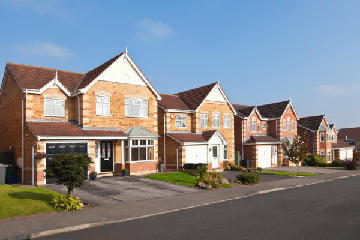

In [3]:
width, height = img.size 
newsize = (int(width*0.6), int(height*0.6))
img = img.resize(newsize)
display(img)

In [4]:
img = np.array(img)
img_data = np.zeros((img.shape[0], img.shape[1], 5))
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        img_data[i,j,0:3] = img[i,j]/255
        img_data[i,j,3] = i/img.shape[0]
        img_data[i,j,4] =  j/img.shape[1]
img_data = img_data.reshape(((img.shape[0]*img.shape[1], 5))).T
print(img_data.shape)

(5, 86400)


In [5]:
fcm = fuzz.cluster.cmeans(img_data, 25, 2, error=0.05, maxiter=1000, init=None)

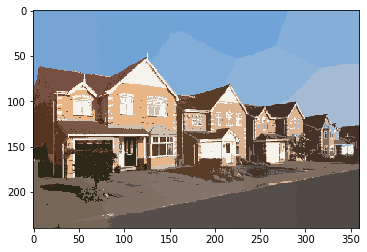

In [6]:
cluster_centers = fcm[0]
prob_matrix = fcm[1]
pred_matrix = np.argmax(prob_matrix, axis = 0)
pred_matrix = cluster_centers[pred_matrix]
clustered_image = pred_matrix[:,0:3]
clustered_image = clustered_image.reshape(((img.shape[0],img.shape[1], 3)))*255
clustered_image = clustered_image.astype(int)
plt.imshow(clustered_image)

### Question 2
**Write a program to obtain the spatial and contrast cues using SLIC superpixels of an image instead of pixels. [3 marks]**

(256, 256, 3)


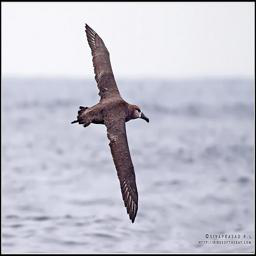

In [329]:
img_path = 'Black_Footed_Albatross_0009_34.jpg'

image  = cv2.imread(img_path)
# plt.imshow(image)
print(image.shape)
display(Image.open(img_path))

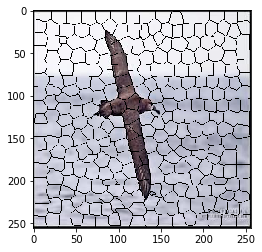

In [330]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#Initialize the slic item, the average size of super pixels is 20 (default is 10), and the smoothing factor is 20
slic = cv2.ximgproc.createSuperpixelSLIC(img,region_size=15,ruler = 20.0) 
slic.iterate(40)     #Number of iterations, the greater the better
mask_slic = slic.getLabelContourMask() #Get Mask, Super pixel edge Mask==1
label_slic = slic.getLabels()        #Get superpixel tags
number_slic = slic.getNumberOfSuperpixels()  #Get the number of super pixels
mask_inv_slic = cv2.bitwise_not(mask_slic)  
img_slic = cv2.bitwise_and(img,img,mask =  mask_inv_slic) #Draw the superpixel boundary on the original image
cv2.imshow("img_slic",img_slic)
plt.imshow(img_slic)


In [331]:
label_slic

array([[  1,   1,   1, ...,  16,  16,  16],
       [  1,   1,   1, ...,  16,  16,  16],
       [  1,   1,   1, ...,  16,  16,  16],
       ...,
       [272, 272, 272, ..., 288, 288, 288],
       [272, 272, 272, ..., 288, 288, 288],
       [272, 272, 272, ..., 288, 288, 288]], dtype=int32)

In [332]:
def get_super_image(image, segments):
    
    m,n = segments.shape
    
    dict_ = {}
    centers = {}

    for i in range(m):
        for j in range(n):
            if(segments[i,j] not in dict_):
                dict_[segments[i,j]] = []
                centers[segments[i,j]] = []
                dict_[segments[i,j]].append(image[i,j])
                centers[segments[i,j]].append(np.array([i,j]))
            else :
                dict_[segments[i,j]].append(image[i,j])
                centers[segments[i,j]].append(np.array([i,j]))
    for key in list(dict_.keys()):
        dict_[key] = np.mean(np.array(dict_[key]), 0).astype(int)
        centers[key] = np.mean(np.array(centers[key]), 0).astype(int)
            
    slic_image = np.zeros((image.shape[0],image.shape[1],3))
    
    for i in range(m):
        for j in range(n):
            slic_image[i,j] =  dict_[segments[i,j]]
    slic_image = slic_image.astype(int)
    
#     print(slic_image)
    plt.imshow(slic_image)
    plt.title("SLIC Image")
    
    return slic_image, dict_, centers

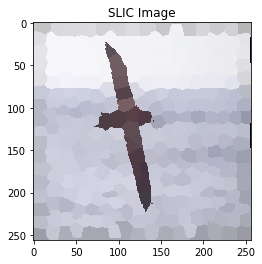

In [333]:
slic_image, dict_pixels, dict_centers = get_super_image(img,label_slic)

![title](contrast_cue_formula.PNG)
![title](spatial_cue_formula.PNG)

In [334]:
def contrast_spatial_cue(slic_image, dict_pixels, label_slic, dict_centers, k = 10):
    m,n = label_slic.shape
    
    data = np.zeros((len(list(dict_pixels.keys())), 3))
    l = sorted(list(dict_pixels.keys()))
    for i in range(len(l)):
        data[i] = dict_pixels[l[i]]
    
    print(data.shape)
    data = np.float32(data)/255
    
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, (centers) = cv2.kmeans(data, k, None, criteria, 100, cv2.KMEANS_RANDOM_CENTERS)

    pred_matrix = np.squeeze(labels)
    cluster_dist = cdist(centers,centers, 'euclidean')
    clustered_img = pred_matrix[label_slic]

    n_i = {}
    for i in np.unique(clustered_img):
        n_i[i] = np.count_nonzero(clustered_img == i)
    print(n_i)
    
    contrast_cues = {}
    for i in range(k):
        val = 0
        for j in range(k):
            if(i!=j):
                val+=(n_i[j]/(clustered_img.shape[0]*clustered_img.shape[1]))*cluster_dist[i,j]
        contrast_cues[i] = val
    print("\033[1mContrast Cues : \033[0m",contrast_cues)
    
    
    center_data = np.zeros((len(list(dict_centers.keys())), 2))
    l = sorted(list(dict_centers.keys()))
    for i in range(len(l)):
        a,b = dict_centers[l[i]]
        center_data[i,0] = a
        center_data[i,1] = b
    slic_image_center = dict_centers[label_slic[m//2,n//2]].reshape((1,2))
    slic_image_center[0,0] = slic_image_center[0,0]
    slic_image_center[0,1] = slic_image_center[0,1]
    slic_center_dist = cdist(center_data,slic_image_center,'euclidean')
    slic_center_dist_var = np.var(slic_center_dist)
#     print(slic_center_dist)
    
    spatail_cues = {}
    for c in range(k):
        val = 0
        for i in range(len(slic_center_dist)):
            if(pred_matrix[i] == c):
                val+=scipy.stats.norm(0, slic_center_dist_var).pdf(slic_center_dist[i,0])
        val = val/np.count_nonzero(pred_matrix == c)
        spatail_cues[c] = val
    
                
    print("\033[1mSpatial Cues : \033[0m",spatail_cues) 
    
    final_image = np.zeros(((m,n)))
    for i in range(m):
        for j in range(n):
            idx = clustered_img[i,j]
            val = spatail_cues[idx]*contrast_cues[idx]
            
            final_image[i,j] = val
    
    plt.imshow(final_image, cmap = 'gray')
    
        
    
      
    

(289, 3)
{0: 183, 1: 260, 2: 27455, 3: 214, 4: 1709, 5: 2974, 6: 209, 7: 59, 8: 1872, 9: 6569, 10: 762, 11: 4444, 12: 2380, 13: 9009, 14: 7437}
Contrast Cues :  {0: 0.3601002532773467, 1: 0.356174104131118, 2: 0.15350685006681314, 3: 0.3424132437420521, 4: 0.7517534405329303, 5: 0.2741942042484321, 6: 0.2315384323923861, 7: 1.322941425120224, 8: 0.25298545087467483, 9: 0.20463652277874675, 10: 0.31574435727443745, 11: 0.2676398894451686, 12: 0.8980197710581226, 13: 0.30467215892027844, 14: 0.19003610461871873}
Spatial Cues :  {0: 0.00030104403784432727, 1: 0.0002998607167547914, 2: 0.00030147952964202225, 3: 0.00029961365615270157, 4: 0.0003019163296866104, 5: 0.00030128314978925685, 6: 0.00029986174946870146, 7: 0.00030055587130579703, 8: 0.0003008263577771145, 9: 0.00030120194268760806, 10: 0.00030072058084827007, 11: 0.00030095140884253436, 12: 0.0003020433658029685, 13: 0.0003012582197549124, 14: 0.00030110583695128364}


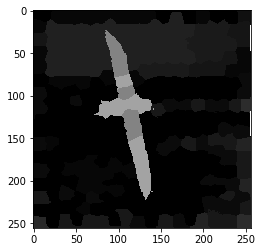

In [336]:
contrast_spatial_cue(slic_image, dict_pixels, label_slic, dict_centers, 15)